# node2vec

> TBD

In [ ]:
#| default_exp graphml.node2vec

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset, download_url
import zipfile
import networkx as nx


class NetworkxFootballGraph(InMemoryDataset):
    def __init__(
        self, root, transform=None, 
        pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['football.zip']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"
        download_url(url, self.raw_dir)

    def process(self):
        zf = zipfile.ZipFile(self.raw_dir + "/" + self.raw_file_names[0])  # zipfile object
        # txt = zf.read("football.txt").decode()  # info file
        gml = zf.read("football.gml").decode()  # read gml data
        # throw away bogus first line with # from mejn files
        gml = gml.split("\n")[1:]
        G = nx.parse_gml(gml)
        data_list = [from_networkx(G)]
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
#| hide
from pathlib import Path

data_path = Path("../data")
if not data_path.exists():
    data_path.mkdir()

football_dataset = NetworkxFootballGraph(root=data_path)

In [ ]:
#| hide
football_dataset.len()

1

In [ ]:
#| hide
football_dataset.get(0)

Data(edge_index=[2, 1226], value=[115], num_nodes=115)

In [ ]:
#| hide
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#| hide
from torch_geometric.nn import Node2Vec

model = Node2Vec(
    football_dataset.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)

In [ ]:
#| export
import sys

def train(model):
    num_workers = 0 if sys.platform.startswith('win') else 4
    loader = model.loader(
        batch_size=128, 
        shuffle=True,
        num_workers=num_workers)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    overall_loss = total_loss / len(loader)
    return overall_loss

In [ ]:
#| hide
loss = train(model)

In [ ]:
#| export
# Get k-nearest neighbors for the embedded nodes
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

@torch.no_grad()
def get_kmeans(model, data, components: int = 2, max_clusters: int = 6):
    clusters = {}
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=components).fit_transform(z.cpu().numpy())
    clusters["data"] = z
    clusters["clusters"] = {}
    for i in range(2, max_clusters):
        i_k_means = KMeans(
            n_clusters=i, 
            n_init=10
        ).fit(z)
        i_clusters = i_k_means.predict(z)
        clusters["clusters"][i] = {
            "labels": i_clusters,
            "algo": i_k_means,
        }
    return clusters

In [ ]:
#| hide
clusters = get_kmeans(model, football_dataset.get(0))
clusters.get("clusters").get(2).get("labels")

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0], dtype=int32)

In [ ]:
#| export
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(n_clusters: int, data, labels, algo):
    fig, ax = plt.subplots()
    centers = algo.cluster_centers_

    ax.scatter(data[:, 0], data[:, 1], s=10, c=algo.labels_)
    ax.scatter(centers[:, 0], centers[:, 1], c="r", s=20)

    ax.set_title(f"KMeans : {n_clusters} clusters")
    
    plt.show()

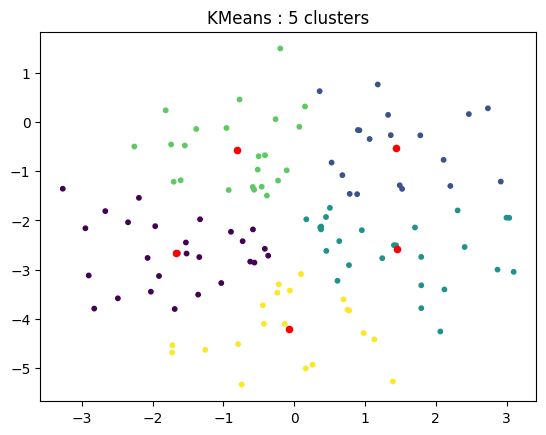

In [ ]:
#| hide
cluster_n = 5
cluster_n_data = clusters.get("clusters").get(cluster_n)
plot_clusters(
    n_clusters=cluster_n, 
    data=clusters.get("data"),
    labels=cluster_n_data.get("labels"),
    algo=cluster_n_data.get("algo")
)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()